For these tests we will solve an 100x100 system of linear differential equations. This will demonstrate the efficiency of the methods for handling large systems. We will be mostly looking at the efficiency of the work-horse Dormand-Prince Order 4/5 Pairs: one from DifferentialEquations.jl (`:DP5`, one from ODE.jl `:ode45`, and one from ODEInterface: Hairer's famous `:dopri5`).

In [12]:
using DifferentialEquations

# 2D Linear ODE
f = (t,u,du) -> begin
  for i in 1:length(u)
    du[i] = 1.01*u[i]
  end
end
analytic = (t,u₀) -> u₀*exp(1.01*t)
prob = ODEProblem(f,rand(100,100),analytic=analytic)

tspan = [0,1]
abstols = 1./10.^(3:13)
reltols = 1./10.^(0:10);

### Speed Baseline

First a baseline. These settings make DifferentialEquations match the Hairer algorithm. Note that ODE.jl does not feature Lund stabilization and so it is unaffected by the β and expo1 choices. Extra saving features are turned off to put DifferentialEquations.jl in "speed mode".


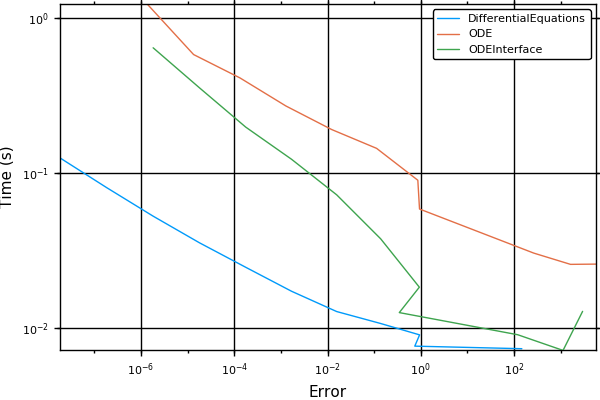

In [13]:
tspan = [0,10]
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:ode45)
          Dict(:alg=>:dopri5)]
names = ["DifferentialEquations";"ODE";"ODEInterface"]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;names=names,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=false,dense=false,save_timeseries=false)
plot(wp)

DifferentialEquations.jl has is clearly far in the lead, being more than an order of magnitude faster for the same amount of error. One significant factor is the normalization choice within the error estimate. If we change this, we receive the following:

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.



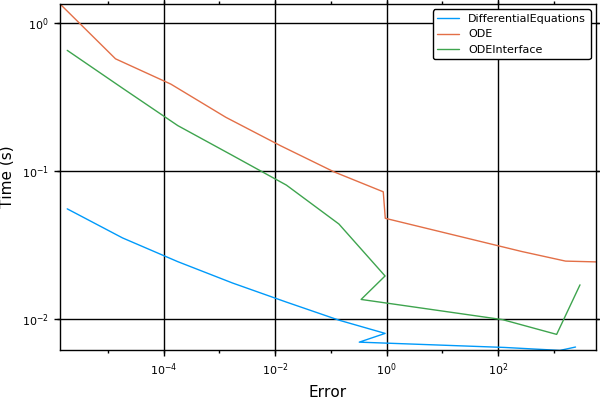

In [3]:
tspan = [0,10]
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:ode45)
          Dict(:alg=>:dopri5)]
names = ["DifferentialEquations";"ODE";"ODEInterface"]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;names=names,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=true,dense=false,save_timeseries=false)
plot(wp)

Not as good but still clearly dominant.

### Full Saving

Now if we include full saving at every timestep, we receive the following:


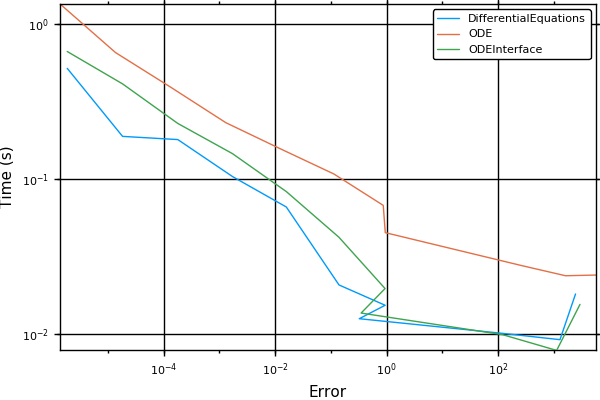

In [4]:
tspan = [0,10]
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:ode45)
          Dict(:alg=>:dopri5)]
names = ["DifferentialEquations";"ODE";"ODEInterface"]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;names=names,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=true,dense=false)
plot(wp)

While not as dramatic as before, DifferentialEquations.jl is still far in the lead. Since the times are log scaled, this comes out to be about a 2x lead ove ODEInterface, and about a 5-10x lead over ODE.jl

### Continuous Output

Now we include continuous output. This has a large overhead because at every timepoint the matrix of rates `k` has to be deep copied. This feature is also only in DifferentialEquations.jl, but leads to the nice `sol(t)` output.


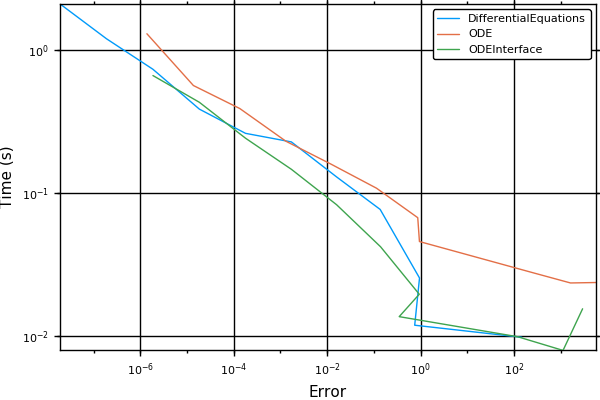

In [5]:
tspan = [0,10]
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:ode45)
          Dict(:alg=>:dopri5)]
names = ["DifferentialEquations";"ODE";"ODEInterface"]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;names=names,β=0.04,expo1=.17,qmin=0.2,qmax=10.0)
plot(wp)

As you can see, even with this large overhead, DifferentialEquations.jl essentially ties with ODEInterface. This shows that the fully featured `:DP5` solver holds its own with even the classic "great" methods.

### Other Runge-Kutta Algorithms

Now let's test it against a smattering of other Runge-Kutta algorithms. First we will test it with all overheads off. Let's do the Order 5 (and the 2/3 pair) algorithms:


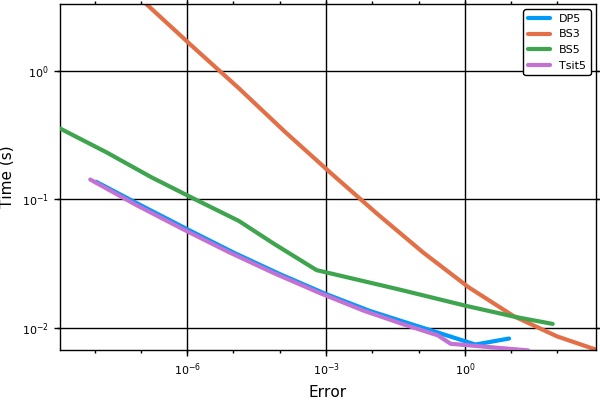

In [6]:
tspan = [0,10]
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:BS3)
          Dict(:alg=>:BS5)
          Dict(:alg=>:Tsit5)]
names = ["DifferentialEquations";"ODE";"ODEInterface"]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;β=0.07,dense=false,save_timeseries=false,numruns=100)
plot(wp,lw=3)

As you can see, `:DP5` tends to be more efficient than the Bogacki-Shampine algorithms, and ties the Tsitorous algorithm. Now let's see how it fairs against some higher order algorithms:


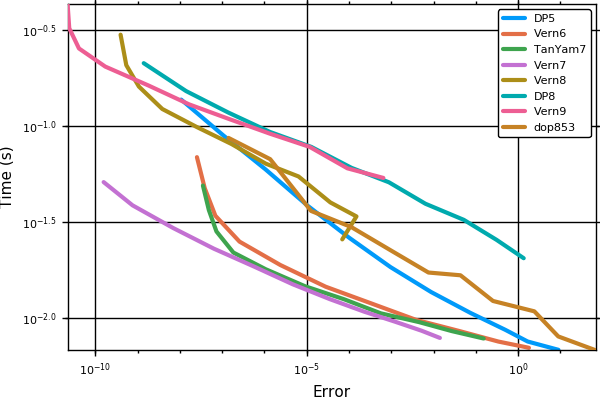

In [7]:
tspan = [0,10]
setups = [Dict(:alg=>:DP5)       
          Dict(:alg=>:Vern6)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:Vern9)
          Dict(:alg=>:dop853)]
names = ["DifferentialEquations";"ODE";"ODEInterface"]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;β=0.07,dense=false,save_timeseries=false,numruns=100)
plot(wp,lw=3)

Here `:Vern7` does very well, with `:TanYam7` and `:Vern6` doing good as well.There are far ahead of the other algorithms, including the revered `dop853`. This puts DifferentialEquations.jl in the #1 spot in this challenge.

### Playing Around with other Setups


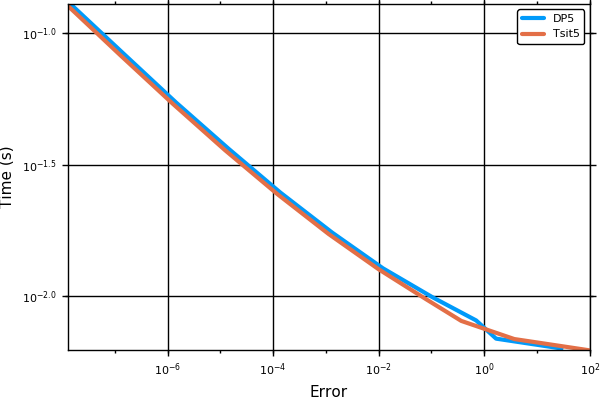

In [9]:
tspan = [0,10]
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:Tsit5)]
names = ["DifferentialEquations";"ODE";"ODEInterface"]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;β=0.07,expo1=.17,dense=false,save_timeseries=false,numruns=100)
plot(wp,lw=3)


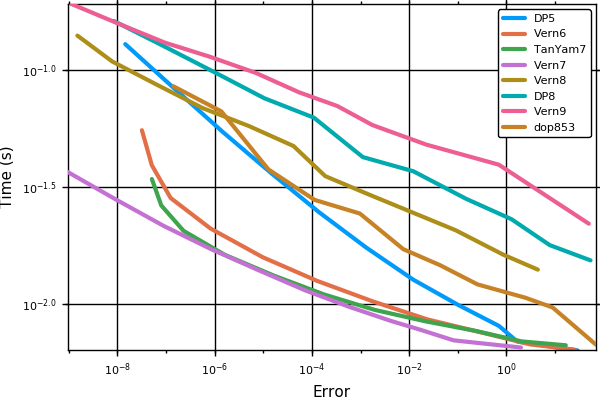

In [10]:
tspan = [0,10]
setups = [Dict(:alg=>:DP5)       
          Dict(:alg=>:Vern6)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:Vern9)
          Dict(:alg=>:dop853)]
names = ["DifferentialEquations";"ODE";"ODEInterface"]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;β=0.07,expo1=.17,dense=false,save_timeseries=false,numruns=100)
plot(wp,lw=3)


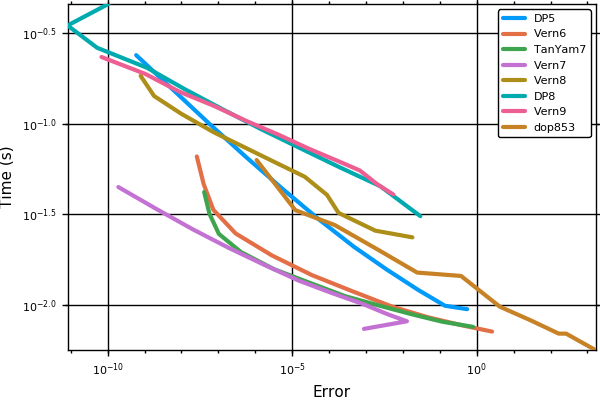

In [11]:
tspan = [0,10]
setups = [Dict(:alg=>:DP5)       
          Dict(:alg=>:Vern6)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:Vern9)
          Dict(:alg=>:dop853)]
names = ["DifferentialEquations";"ODE";"ODEInterface"]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;dense=false,save_timeseries=false,numruns=100)
plot(wp,lw=3)